In [17]:
import cPickle, string, numpy, getopt, sys, random, time, re
import onlineldavb

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

### Import the dataset

In [19]:
import pickle
wds=pickle.load(open("MSRvid.p",'rb'))

documents = []

for i in wds:
    documents.append(i[0]) 
    documents.append(i[1]) 

## Set parameters for SVI

In [32]:
K = 3 #Number of topics
D = len(documents) #Number of documents
batchsize = 16
num_iterations = 4000
kappa = 0.9 #Learning rate

In [35]:
len(vocab)

1075

## Get vocabulary

### (Optionally remove most frequent and most infrequent)

In [23]:
def getMeanVocab(vectorizer, num_std=1):
    vocab = []
    most_frequent = numpy.max(vectorizer.vocabulary_.values())
    vocab_std = numpy.std(vectorizer.vocabulary_.values())
    vocab_mean = numpy.mean(vectorizer.vocabulary_.values())

    print "Num vocab: %d\nMost frequent: %d\nMean: %d\nStd: %d" % \
        (len(vectorizer.vocabulary_), most_frequent, vocab_mean, vocab_std)

    removed = 0
    for key in vectorizer.vocabulary_:
        if vectorizer.vocabulary_[key] > vocab_mean - num_std*vocab_std and \
            vectorizer.vocabulary_[key] < vocab_mean + num_std*vocab_std:
            vocab.append(key)
        else:
            removed = removed + 1
    print('Number of stopwords removed: %d' % removed)
    return vocab

### (Optionally remove stopwords)

In [24]:
with open("stopwords.p", 'r') as f:
    sw = pickle.load(f)

def remove_stop(vocabulary):
    new_vocab = []
    removed = 0
    for i in vocabulary:
        if i not in sw:
            new_vocab.append(i)
        else:
            removed = removed + 1
    print('Number of stopwords removed: %d' % removed)
    return new_vocab

### Tokenize documents to get vocabulary

In [36]:
vectorizer = CountVectorizer()
vectors = vectorizer.fit(documents)

vocab = remove_stop(vectorizer.vocabulary_.keys()) #, getVocab(vectors)   
print('Size of vocab: %d' % len(vocab))

Number of stopwords removed: 54
Size of vocab: 1075


## Function to get mini-batch

In [37]:
from random import sample

def getbatch(size, iteration):
    
    sample_idx = sample(range(D), size)
    return [documents[i] for i in sample_idx]

## Train LDA model using SVI

In [ ]:
print "Parameters: \n\t Num topics: %d \n\t Num documents: %d" % (K, D)
print "\t prior on weight vectors (theta): %4.2f \n\t prior on topics (beta): %4.2f" % (1./K, 1./K)
print "\t burn in rate: %4.2f \n\t learning rate: %4.2f" % (1024., kappa)

rho = []
perplex = []
elogbeta = []
lambdaVar = []
num_iterations=1000
olda = onlineldavb.OnlineLDA(vocab, K, D, 1./K, 1./K, 1024., kappa)
for iteration in range(0, num_iterations):
    docset=getbatch(batchsize,iteration)
    (gamma, bound) = olda.update_lambda(docset)
    (wordids, wordcts) = onlineldavb.parse_doc_list(docset, olda._vocab,False)
    perwordbound = bound * len(docset) / (D * sum(map(sum, wordcts)))
    rho.append(olda._rhot,)
    perplex.append(numpy.exp(-perwordbound))
    elogbeta.append(olda._Elogbeta)
    lambdaVar.append(olda._lambda)
    
    if (iteration % 50 == 0):
        print "Training iteration %d" % iteration
        

            
print "Done training"

Parameters: 
	 Num topics: 3 
	 Num documents: 1500
	 prior on weight vectors (theta): 0.33 
	 prior on topics (beta): 0.33
	 burn in rate: 1024.00 
	 learning rate: 0.90
Training iteration 0
Training iteration 50
Training iteration 100
Training iteration 150
Training iteration 200
Training iteration 250
Training iteration 300
Training iteration 350
Training iteration 400
Training iteration 450
Training iteration 500
Training iteration 550
Training iteration 600
Training iteration 650
Training iteration 700
Training iteration 750
Training iteration 800
Training iteration 850
Training iteration 900
Training iteration 950
Training iteration 1000
Training iteration 1050
Training iteration 1100
Training iteration 1150
Training iteration 1200
Training iteration 1250
Training iteration 1300
Training iteration 1350
Training iteration 1400
Training iteration 1450
Training iteration 1500
Training iteration 1550
Training iteration 1600
Training iteration 1650
Training iteration 1700
Training ite

## Convergence visualization

In [28]:
import warnings
warnings.filterwarnings('ignore')

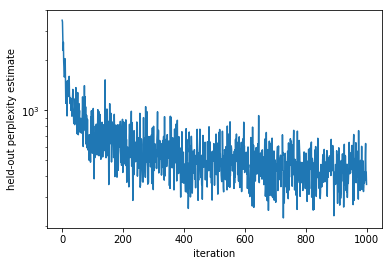

In [29]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure()
plt.semilogy(range(len(perplex)), perplex)
plt.ylabel('held-out perplexity estimate')
plt.xlabel('iteration')
plt.show()

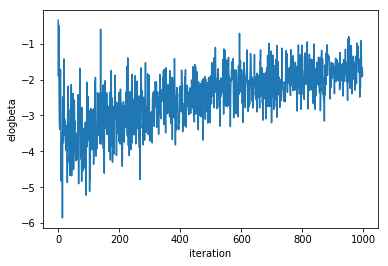

In [30]:
beta_convergence = [numpy.sum(elogbeta[i+1]-elogbeta[i]) for i in range(1, len(elogbeta)-1)]

plt.figure()
plt.plot(range(len(beta_convergence)), beta_convergence)
plt.ylabel('elogbeta')
plt.xlabel('iteration')
plt.show()


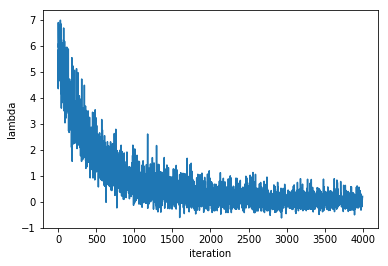

In [12]:
#print(lambdaVar)
#print(lambdaVar[0].shape)
lambda_convergence = [numpy.sum(lambdaVar[i+1]-lambdaVar[i]) for i in range(1, len(lambdaVar)-1)]

plt.figure()
plt.plot(range(len(lambda_convergence)), lambda_convergence)
plt.ylabel('lambda')
plt.xlabel('iteration')
plt.show()

## Print vocabulary per topic

In [34]:
num_vocab_display = 5

for k in range(0, len(olda._lambda)):
    lambdak = list(olda._lambda[k, :])
    lambdak = lambdak / sum(lambdak)
    temp = zip(lambdak, range(0, len(lambdak)))
    temp = sorted(temp, key = lambda x: x[0], reverse=True)
    print 'topic %d:' % (k)
    for i in range(0, num_vocab_display):
        print '%20s  \t---\t  %.4f' % (vocab[temp[i][1]], temp[i][0])
    print

topic 0:
                 man  	---	  0.1460
               woman  	---	  0.0887
             playing  	---	  0.0544
             slicing  	---	  0.0250
              guitar  	---	  0.0247

topic 1:
                 cat  	---	  0.0372
                 dog  	---	  0.0339
             walking  	---	  0.0295
               water  	---	  0.0132
              monkey  	---	  0.0114

topic 2:
              eating  	---	  0.0337
                 men  	---	  0.0240
             running  	---	  0.0184
                ball  	---	  0.0148
                 boy  	---	  0.0138



## Variational Inference w/ no Stochastisisty

In [42]:
print "Parameters: \n\t Num topics: %d \n\t Num documents: %d" % (K, D)
print "\t prior on weight vectors (theta): %4.2f \n\t prior on topics (beta): %4.2f" % (1./K, 1./K)
print "\t burn in rate: %4.2f \n\t learning rate: %4.2f" % (1024., 0)

rho = []
perplex = []

olda = onlineldavb.OnlineLDA(vocab, K, D, 1./K, 1./K, 1024., 0)
for iteration in range(0, num_iterations):
    docset=documents
    (gamma, bound) = olda.update_lambda(docset)
    (wordids, wordcts) = onlineldavb.parse_doc_list(docset, olda._vocab,False)
    perwordbound = bound * len(docset) / (D * sum(map(sum, wordcts)))
    rho.append(olda._rhot,)
    perplex.append(numpy.exp(-perwordbound))
    
    if (iteration % 50 == 0):
        print "Training iteration %d" % iteration
        

            
print "Done training"

Parameters: 
	 Num topics: 3 
	 Num documents: 1500
	 prior on weight vectors (theta): 0.33 
	 prior on topics (beta): 0.33
	 burn in rate: 1024.00 
	 learning rate: 0.00
Training iteration 0


KeyboardInterrupt: 

In [ ]:
plt.figure()
plt.semilogy(range(len(perplex)), perplex)
plt.ylabel('held-out perplexity estimate')
plt.xlabel('iteration')
plt.show()